In [155]:
from pathlib import Path

DATA_PATH = Path("/mnt/e/dev/data/luna")
ANNOTATIONS_PATH = DATA_PATH / "annotations.csv"
CANDIDATES_PATH = DATA_PATH / "candidates.csv"

In [156]:
import pandas as pd

annotations_df = pd.read_csv(filepath_or_buffer=ANNOTATIONS_PATH)
annotations_df.head()

,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150


In [157]:
candidates_df = pd.read_csv(filepath_or_buffer=CANDIDATES_PATH)
candidates_df.head()

,seriesuid,coordX,coordY,coordZ,class
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-56.08,-67.85,-311.92,0
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,53.21,-244.41,-245.17,0
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.66,-121.80,-286.62,0
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-33.66,-72.75,-308.41,0
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-32.25,-85.36,-362.51,0


In [158]:
print(f"annotations.shape={annotations_df.shape}")
print(f"candidates.shape={candidates_df.shape}")
print("=" * 30)

# 0 - non-nodule, 1 - nodule (doesn't have to be malignant)
candidates_nodule_df = candidates_df[candidates_df['class'] == 1]
candidates_non_nodule_df = candidates_df[candidates_df['class'] == 0]

print(f"candidates_nodule_df.shape={candidates_nodule_df.shape}")
print(f"candidates_non_nodule_df.shape={candidates_non_nodule_df.shape}")

annotations.shape=(1186, 5)
candidates.shape=(551065, 5)
candidates_nodule_df.shape=(1351, 5)
candidates_non_nodule_df.shape=(549714, 5)


In [159]:
candidates = candidates_df[
    (candidates_df['seriesuid'] == "1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860") &
    (candidates_df['class'] == 1)
    ]

annotated_candidates = annotations_df[
    (annotations_df['seriesuid'] == "1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860")
]


"""
Doctor annoted data from annotations.csv has different X, Y, Z coordinates than the automatic nodule detection data in candidates.csv

annotations.csv: ground truth, manually annotated by radiologists
candidates.csv: output of automatic nodule detection algorithm, class == 1 if it falls within the doctor annotated nodule diameter
"""
print(candidates.iloc[1])
print(annotated_candidates.iloc[0])

seriesuid    1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...
coordX                                                 -128.94
coordY                                                 -175.04
coordZ                                                 -297.87
class                                                        1
Name: 78, dtype: object
seriesuid      1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...
coordX                                               -128.699421
coordY                                               -175.319272
coordZ                                               -298.387506
diameter_mm                                             5.651471
Name: 0, dtype: object


In [160]:
from collections import namedtuple
import math

CandidateInfoTuple = namedtuple(
    typename="CandidateInfoTuple",
    field_names=["is_nodule", "diameter_mm", "series_uid", "center_xyz"],
)

def _coord_distance(first_coord, second_coord):
    return math.sqrt(
        (first_coord[0] - second_coord[0]) ** 2 +
        (first_coord[1] - second_coord[1]) ** 2 +
        (first_coord[2] - second_coord[2]) ** 2
    )

def getCandidateInfo(annotations_path: str, candidates_path: str) -> list[CandidateInfoTuple]:
    annotations_df = pd.read_csv(filepath_or_buffer=annotations_path)
    candidates_df = pd.read_csv(filepath_or_buffer=candidates_path)

    AnnotationTuple = namedtuple(
        typename="AnnotationTuple",
        field_names=["seriesuid", "coord", "diameter"],
    )

    annotations_dict: dict[list[AnnotationTuple]] = {}
    for row in annotations_df.itertuples():
        annotations_dict.setdefault(row.seriesuid, []).append(
            AnnotationTuple(
                seriesuid=row.seriesuid,
                coord=(row.coordX, row.coordY, row.coordZ),
                diameter=row.diameter_mm,
            )
        )

    candidate_info_list: list[CandidateInfoTuple] = []
    for row in candidates_df.itertuples():
        series_uid = row.seriesuid
        coordX, coordY, coordZ = row.coordX, row.coordY, row.coordZ
        is_nodule = row[5] # .class is a reserved keyword in Python
        diameter_mm = 0

        if series_uid in annotations_dict:
            current_coord = (coordX, coordY, coordZ)
            for annotation in annotations_dict[series_uid]:
                if _coord_distance(annotation.coord, current_coord) < annotation.diameter / 4:
                    diameter_mm = annotation.diameter
                    break

        candidate_info_list.append(
            CandidateInfoTuple(
                is_nodule=bool(is_nodule), # TODO: fix for cross entropy
                diameter_mm=diameter_mm,
                series_uid=series_uid,
                center_xyz=(coordX, coordY, coordZ),
            )
        )

    return candidate_info_list

candidates_info = getCandidateInfo(
    annotations_path=ANNOTATIONS_PATH,
    candidates_path=CANDIDATES_PATH,
)

candidates_info.sort(reverse=True)
print(candidates_info[:10])
print(sum(candidates_info[i].diameter_mm > 0 for i in range(len(candidates_info))))

[CandidateInfoTuple(is_nodule=True, diameter_mm=32.27003025, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886', center_xyz=(67.61451718, 85.02525992, -109.8084416)), CandidateInfoTuple(is_nodule=True, diameter_mm=30.61040636, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.112740418331256326754121315800', center_xyz=(47.90350511, 37.60442008, -99.93417567)), CandidateInfoTuple(is_nodule=True, diameter_mm=27.44242293, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.943403138251347598519939390311', center_xyz=(-45.29440163, 74.86925386, -97.52812481)), CandidateInfoTuple(is_nodule=True, diameter_mm=27.07544345, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.481278873893653517789960724156', center_xyz=(-102.571208, -5.186558766, -205.1033412)), CandidateInfoTuple(is_nodule=True, diameter_mm=26.83708074, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.487268565754493433372433148666', center_xyz=(121.152909372, 12.9136003304, -159.399497186)), CandidateInfoTuple(is_nodu

In [161]:
series_uid = "1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860"
list(DATA_PATH.rglob(f"subset*/{series_uid}.mhd"))[0]

PosixPath('/mnt/e/dev/data/luna/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860.mhd')

In [162]:
import numpy as np

def irc_to_xyz(coord_irc, origin_xyz, vxSize_xyz, direction):
    """IRC = (index, row, col) = (z, y, x)"""
    coord = np.array([coord_irc[2], coord_irc[1], coord_irc[0]])
    coord = vxSize_xyz * coord
    coord = direction @ coord
    coord = coord + origin_xyz
    
    return coord


def xyz_to_irc(coord_xyz, origin_xyz, vxSize_xyz, direction):
    coord = np.array([*coord_xyz])
    coord = coord - origin_xyz
    coord = np.linalg.inv(direction) @ coord
    coord = coord / vxSize_xyz

    return np.array([coord[2], coord[1], coord[0]])

In [163]:
import SimpleITK as sitk


class CTScan:
    def __init__(self, series_uid):
        mhd_path = list(DATA_PATH.rglob(f"subset*/{series_uid}.mhd"))[0]
        ct_mhd = sitk.ReadImage(mhd_path)

        ct_array = np.array(sitk.GetArrayFromImage(image=ct_mhd), dtype=np.float32)
        ct_array.clip(min=-1000, max=1000, out=ct_array) # clip irrelevant information

        self.series_uid = series_uid
        self.ct_array = ct_array

        self.origin_xyz = np.array(ct_mhd.GetOrigin())
        self.vxSize_xyz = np.array(ct_mhd.GetSpacing())
        self.direction = np.array(ct_mhd.GetDirection()).reshape(3, 3)

    def get_raw_candidate(self, candidate_xyz, width_irc):
        candidate_irc = xyz_to_irc(
            candidate_xyz,
            self.origin_xyz,
            self.vxSize_xyz,
            self.direction
        )

        slices: list[slice] = []
        for axis, length in enumerate(width_irc):
            start_pos = int(candidate_irc[axis] - length / 2)
            stop_pos = int(candidate_irc[axis] + length / 2)

            assert length >= 0 and length < self.ct_array.shape[axis]

            if start_pos < 0:
                start_pos = 0
                stop_pos = width_irc[axis]
            
            if stop_pos > self.ct_array.shape[axis]:
                stop_pos = self.ct_array.shape[axis]
                start_pos = stop_pos - length

            slices.append(slice(start_pos, stop_pos))

        return self.ct_array[*slices], candidate_irc


In [164]:
ct_scan = CTScan(series_uid="1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860")
print(ct_scan.origin_xyz, sep="\n\n")
print(ct_scan.vxSize_xyz, sep="\n\n")
print(ct_scan.direction, sep="\n\n")

print("=" * 30)

test_irc = (0.0, 0.0, 0.0)
test_irc_to_xyz = irc_to_xyz(
    coord_irc=test_irc,
    origin_xyz=ct_scan.origin_xyz,
    vxSize_xyz=ct_scan.vxSize_xyz,
    direction=ct_scan.direction,
)
print(f"test_irc={test_irc} to test_xyz={test_irc_to_xyz}")

test_irc_to_xyz_to_irc = xyz_to_irc(
    coord_xyz=test_irc_to_xyz,
    origin_xyz=ct_scan.origin_xyz,
    vxSize_xyz=ct_scan.vxSize_xyz,
    direction=ct_scan.direction,
)
print(f"test_irc_to_xyz={test_irc_to_xyz} to test_irc={test_irc_to_xyz_to_irc}")

[-157.67773 -311.67773 -438.4    ]
[0.64453125 0.64453125 1.79999995]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
test_irc=(0.0, 0.0, 0.0) to test_xyz=[-157.67773 -311.67773 -438.4    ]
test_irc_to_xyz=[-157.67773 -311.67773 -438.4    ] to test_irc=[0. 0. 0.]


In [165]:
import torch
from torch.utils.data import Dataset

class LunaDataset(Dataset):
    def __init__(self, validate_stride=0, validate=False, series_uid=None):
        self.candidate_info_list = getCandidateInfo(annotations_path=ANNOTATIONS_PATH, candidates_path=CANDIDATES_PATH)

        if series_uid:
            self.candidate_info_list = [candidate for candidate in self.candidate_info_list if candidate.series_uid == series_uid]

        if validate:
            assert validate_stride > 0 and validate_stride < len(self.candidate_info_list), f"invalid validation stride: {validate_stride}"
            self.candidate_info_list = self.candidate_info_list[::validate_stride]
        elif validate_stride > 0:
            del self.candidate_info_list[::validate_stride]

        assert self.candidate_info_list

    def __len__(self):
        return len(self.candidate_info_list)

    def __getitem__(self, index):
        assert index >= 0 and index < len(self.candidate_info_list), "index out of range"

        series_uid = self.candidate_info_list[index].series_uid
        xyz = self.candidate_info_list[index].center_xyz
        is_nodule = self.candidate_info_list[index].is_nodule

        ct_scan = CTScan(series_uid)
        candidate, candidate_irc = ct_scan.get_raw_candidate(candidate_xyz=xyz, width_irc=(32, 48, 48))

        candidate_t = torch.tensor(candidate, dtype=torch.float32).unsqueeze(0)
        is_nodule_t = torch.tensor(is_nodule, dtype=torch.long)

        return (candidate_t, is_nodule_t, series_uid, candidate_irc)

In [166]:
luna_dataset_test  = LunaDataset(validate=True, validate_stride=10)
luna_dataset_train = LunaDataset(validate=False, validate_stride=10)

len(luna_dataset_test), len(luna_dataset_train)

(55107, 495958)

In [167]:
luna_dataset = LunaDataset(series_uid="1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860")
len(luna_dataset)

691

In [168]:
def findPositiveSamples(start_ndx=0, limit=100):
    ds = LunaDataset()

    positiveSample_list = []
    for sample_tup in ds.candidate_info_list:
        if sample_tup.is_nodule:
            print(len(positiveSample_list), sample_tup)
            positiveSample_list.append(sample_tup)

        if len(positiveSample_list) >= limit:
            break

    return positiveSample_list

In [169]:
sample_list = findPositiveSamples(start_ndx=0, limit=50)
print(sample_list)

0 CandidateInfoTuple(is_nodule=True, diameter_mm=4.224708481, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860', center_xyz=(104.16480444, -211.685591018, -227.011363746))
1 CandidateInfoTuple(is_nodule=True, diameter_mm=5.651470635, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860', center_xyz=(-128.94, -175.04, -297.87))
2 CandidateInfoTuple(is_nodule=True, diameter_mm=5.786347814, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208', center_xyz=(70.19, -140.93, 877.68))
3 CandidateInfoTuple(is_nodule=True, diameter_mm=0, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405', center_xyz=(89.32, 190.84, -516.82))
4 CandidateInfoTuple(is_nodule=True, diameter_mm=0, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405', center_xyz=(94.93, 153.03, -429.91))
5 CandidateInfoTuple(is_nodule=True, diameter_mm=0, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.1006213

In [170]:
import matplotlib.pyplot as plt

clim=(-1000.0, 300)

def showCandidate(series_uid, batch_ndx=None, **kwargs):
    ds = LunaDataset(series_uid=series_uid, **kwargs)
    pos_list = [i for i, x in enumerate(ds.candidate_info_list) if x.is_nodule]

    if batch_ndx is None:
        if pos_list:
            batch_ndx = pos_list[0]
        else:
            print("Warning: no positive samples found; using first negative sample.")
            batch_ndx = 0

    ct = CTScan(series_uid)
    ct_t, pos_t, series_uid, center_irc = ds[batch_ndx]
    ct_a = ct_t[0].numpy()
    print(series_uid, batch_ndx, bool(pos_t), pos_list)

    fig = plt.figure(figsize=(30, 50))

    group_list = [
        [9, 11, 13],
        [15, 16, 17],
        [19, 21, 23],
    ]

    subplot = fig.add_subplot(len(group_list) + 2, 3, 1)
    subplot.set_title('index {} - axial slice'.format(int(center_irc[0])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct.ct_array[int(center_irc[0])], clim=clim, cmap='gray')

    subplot = fig.add_subplot(len(group_list) + 2, 3, 2)
    subplot.set_title('row {} - coronal slice'.format(int(center_irc[1])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct.ct_array[:,int(center_irc[1])], clim=clim, cmap='gray')
    plt.gca().invert_yaxis()

    subplot = fig.add_subplot(len(group_list) + 2, 3, 3)
    subplot.set_title('col {} - sagital slice'.format(int(center_irc[2])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct.ct_array[:,:,int(center_irc[2])], clim=clim, cmap='gray')
    plt.gca().invert_yaxis()

    subplot = fig.add_subplot(len(group_list) + 2, 3, 4)
    subplot.set_title('index {} - axial slice candidate'.format(int(center_irc[0])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct_a[ct_a.shape[0]//2], clim=clim, cmap='gray')

    subplot = fig.add_subplot(len(group_list) + 2, 3, 5)
    subplot.set_title('row {} - coronal slice candidate'.format(int(center_irc[1])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct_a[:,ct_a.shape[1]//2], clim=clim, cmap='gray')
    plt.gca().invert_yaxis()

    subplot = fig.add_subplot(len(group_list) + 2, 3, 6)
    subplot.set_title('col {} - sagital slice candidate'.format(int(center_irc[2])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct_a[:,:,ct_a.shape[2]//2], clim=clim, cmap='gray')
    plt.gca().invert_yaxis()

    for row, index_list in enumerate(group_list):
        for col, index in enumerate(index_list):
            subplot = fig.add_subplot(len(group_list) + 2, 3, row * 3 + col + 7)
            subplot.set_title('slice {} - axial'.format(index), fontsize=30)
            for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
                label.set_fontsize(20)
            plt.imshow(ct_a[index], clim=clim, cmap='gray')

    plt.show()

1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860 13 True [13, 78]


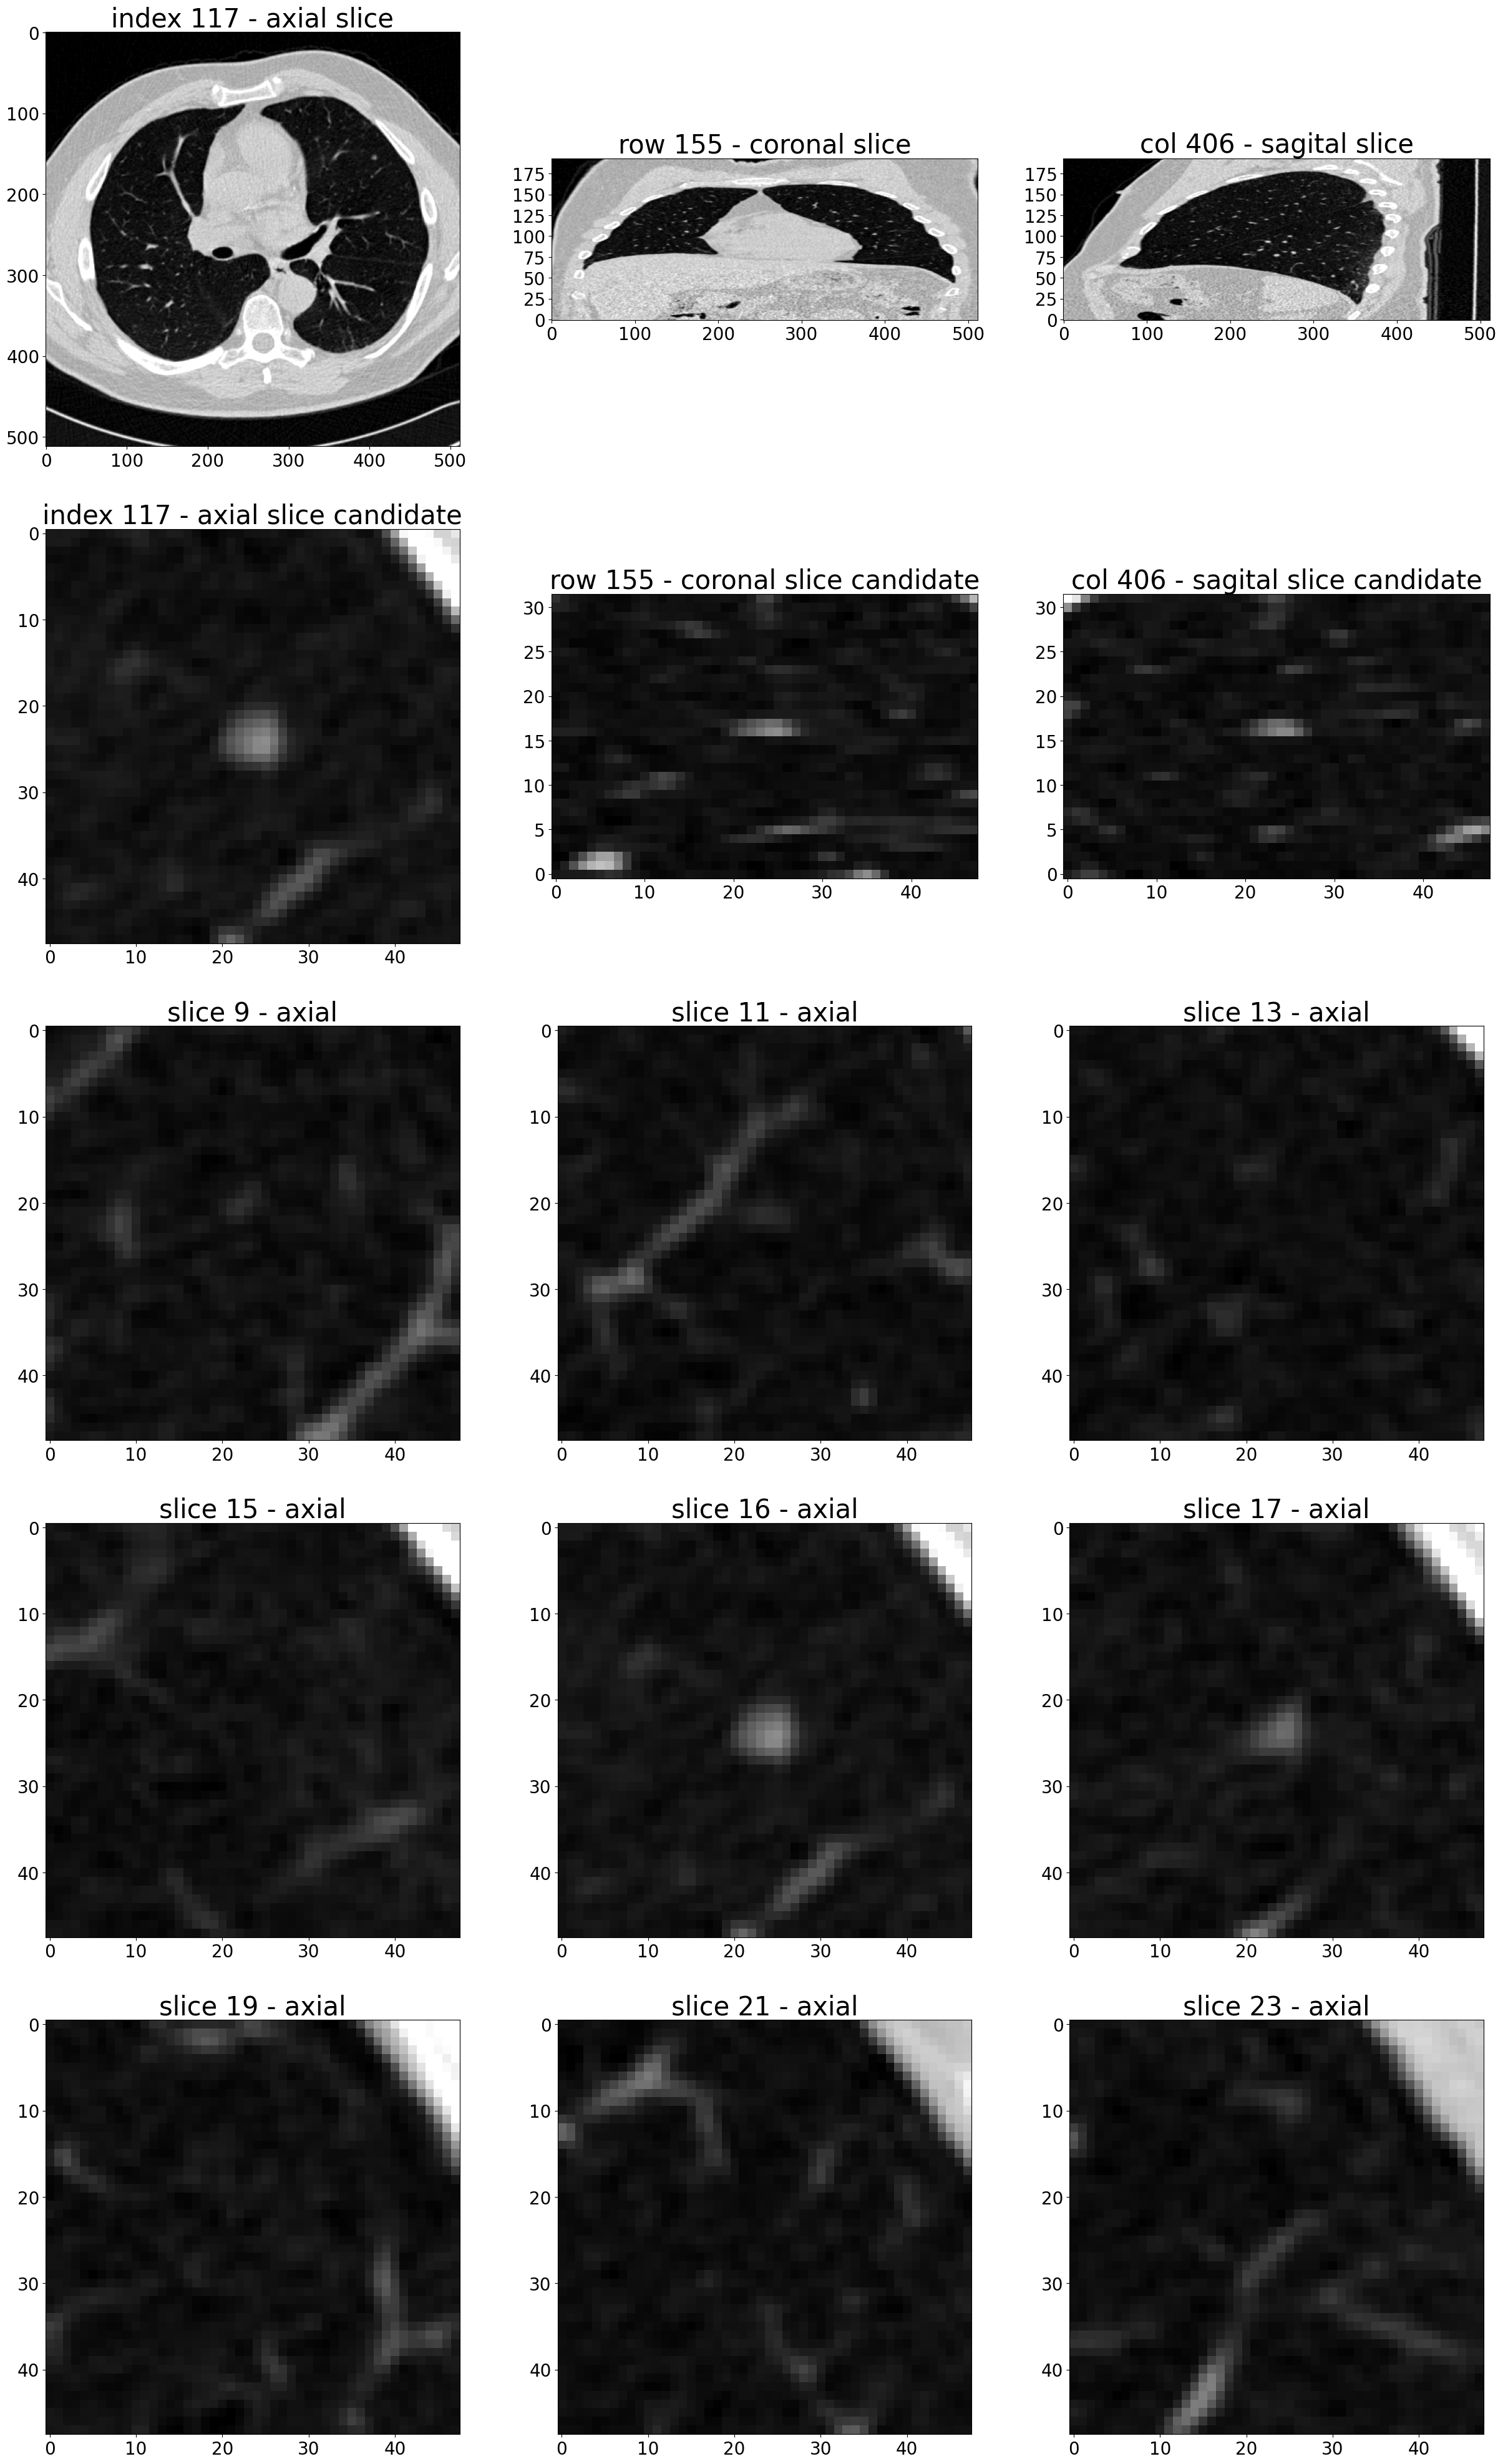

In [171]:
showCandidate(
    series_uid="1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860",
    batch_ndx=13
    )

In [ ]:
import timeit

start = timeit.default_timer()
i = 0
for sample in luna_dataset_train:
    if i == 10:
        break
    i += 1

end = timeit.default_timer()

print(f"time elapsed = {end - start}s")

1
2
3
4
5
6
7
8
9
10
time elapsed = 11.22979894799937
